# We are trying to create a game that will most likely be succesfull. The two major questions we have are
- Which genre will grow the most in the next 10 years?
- Which publisher will sell the most in the next 10 years?


In [42]:
#Load packages
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from itertools import groupby
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')

In [43]:
#Load Dataset
file = "vgsales.csv"
df = pd.read_csv(file)

In [44]:
df.size

182578

In [45]:
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


## Exploratory Analysis & Feature Selection/Engineering

In [46]:
df.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

<AxesSubplot:>

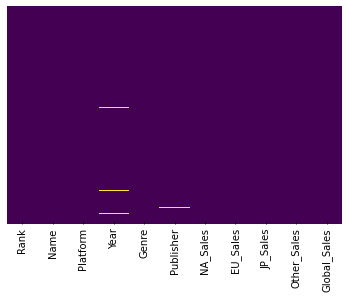

In [47]:
#checking where are the NA values :)
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap='viridis')

In [48]:
df = df.dropna()

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16291 non-null  int64  
 1   Name          16291 non-null  object 
 2   Platform      16291 non-null  object 
 3   Year          16291 non-null  float64
 4   Genre         16291 non-null  object 
 5   Publisher     16291 non-null  object 
 6   NA_Sales      16291 non-null  float64
 7   EU_Sales      16291 non-null  float64
 8   JP_Sales      16291 non-null  float64
 9   Other_Sales   16291 non-null  float64
 10  Global_Sales  16291 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [50]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006-01-01,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985-01-01,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008-01-01,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009-01-01,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


### Publisher,count of games and average sales

In [51]:
publishercount = pd.DataFrame(df.groupby('Publisher').size().reset_index(name='count'))
publishercount.sort_values("count", ascending=False)
publisheravgsales = pd.DataFrame(df.groupby(['Publisher', 'Global_Sales'], as_index=False).mean().groupby('Publisher')['Global_Sales'].mean())
publisher = pd.merge(publishercount, publisheravgsales, on='Publisher').sort_values('count', ascending=False)
publisher = publisher.rename(columns={'Global_Sales':'Global_Avg_Sales'})
publisher.head()

,Publisher,count,Global_Avg_Sales
138,Electronic Arts,1339,1.874050
21,Activision,966,2.219953
347,Namco Bandai Games,928,0.905669
524,Ubisoft,918,1.527181
275,Konami Digital Entertainment,823,1.072536


Text(0.5, 1.0, 'Sales per Publisher since 1980')

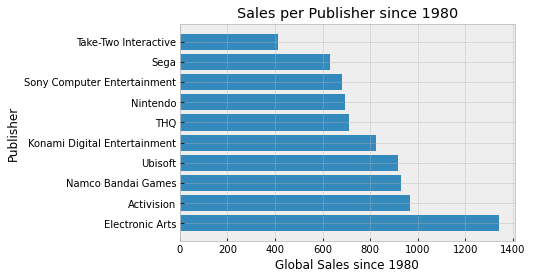

In [52]:
plt.barh(publisher['Publisher'].head(10), publisher['count'].head(10))
plt.xlabel('Global Sales since 1980')
plt.ylabel('Publisher')
plt.title('Sales per Publisher since 1980')

### Genre, count of games and average sales

In [53]:
genrecount = pd.DataFrame(df.groupby('Genre').size().reset_index(name='count'))
genrecount.sort_values("count", ascending=False)
genreavgsales = pd.DataFrame(df.groupby(['Genre', 'Global_Sales'], as_index=False).mean().groupby('Genre')['Global_Sales'].mean())
genre = pd.merge(genrecount, genreavgsales, on='Genre').sort_values('count', ascending=False)
genre = genre.rename(columns={'Global_Sales':'Global_Avg_Sales'})
genre.head()

,Genre,count,Global_Avg_Sales
0,Action,3251,2.483003
10,Sports,2304,2.324170
3,Misc,1686,2.056804
7,Role-Playing,1470,2.415244
8,Shooter,1282,2.559401


Text(0.5, 1.0, 'Sales per Genre since 1980')

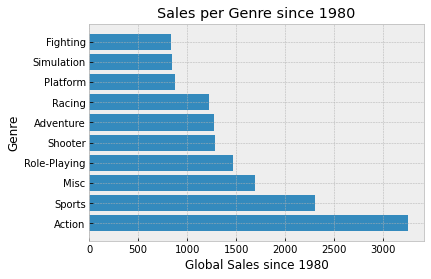

In [54]:
plt.barh(genre['Genre'].head(10), genre['count'].head(10))
plt.xlabel('Global Sales since 1980')
plt.ylabel('Genre')
plt.title('Sales per Genre since 1980')

### Platform, count of games and average sales


In [55]:
platformcount = pd.DataFrame(df.groupby('Platform').size().reset_index(name='count'))
platformcount.sort_values('count',ascending=False)
platformavgsales = pd.DataFrame(df.groupby(['Platform', 'Global_Sales'], as_index=False).mean().groupby('Platform')['Global_Sales'].mean())
platform = pd.merge(platformcount, platformavgsales, on='Platform').sort_values('count', ascending=False)
platform = platform.rename(columns={'Global_Sales':'Global_Avg_Sales'})
platform.head()

,Platform,count,Global_Avg_Sales
4,DS,2131,2.317295
16,PS2,2127,2.118805
17,PS3,1304,2.174706
26,Wii,1290,2.869120
28,X360,1234,2.310345


Text(0.5, 1.0, 'Sales per Platform since 1980')

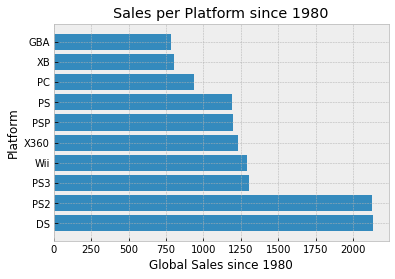

In [56]:
plt.barh(platform['Platform'].head(10), platform['count'].head(10))
plt.xlabel('Global Sales since 1980')
plt.ylabel('Platform')
plt.title('Sales per Platform since 1980')

### Sales after 2010
#### Results might be influenced by total sales per platform overall

In [57]:
df2010 = df.loc[(df['Year'] >= '2010-01-01')]
df2010.size

56474

Text(0.5, 1.0, 'Sales per Genre since 2010')

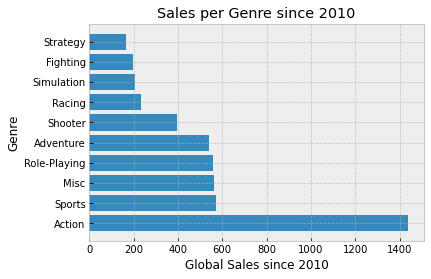

In [58]:
genrecount2010 = pd.DataFrame(df2010.groupby('Genre').size().reset_index(name='count'))
genreavgsales2010 = pd.DataFrame(df2010.groupby(['Genre', 'Global_Sales'], as_index=False).mean().groupby('Genre')['Global_Sales'].mean())
genre2010 = pd.merge(genrecount2010, genreavgsales2010, on='Genre').sort_values('count', ascending=False)
genre2010 = genre2010.rename(columns={'Global_Sales':'Global_Avg_Sales'})
plt.barh(genre2010['Genre'].head(10), genre2010['count'].head(10))
plt.xlabel('Global Sales since 2010')
plt.ylabel('Genre')
plt.title('Sales per Genre since 2010')

Text(0.5, 1.0, 'Sales per Publisher since 2010')

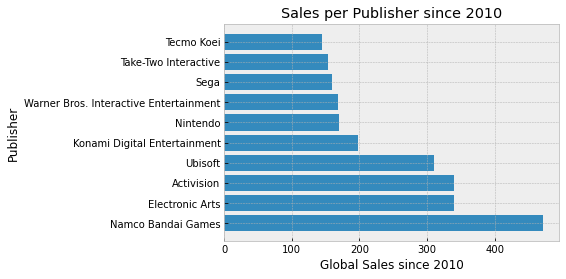

In [59]:
publishercount2010 = pd.DataFrame(df2010.groupby('Publisher').size().reset_index(name='count'))
publisheravgsales2010 = pd.DataFrame(df2010.groupby(['Publisher', 'Global_Sales'], as_index=False).mean().groupby('Publisher')['Global_Sales'].mean())
publisher2010 = pd.merge(publishercount2010, publisheravgsales2010, on='Publisher').sort_values('count', ascending=False)
publisher2010 = publisher2010.rename(columns={'Global_Sales':'Global_Avg_Sales'})
plt.barh(publisher2010['Publisher'].head(10), publisher2010['count'].head(10))
plt.xlabel('Global Sales since 2010')
plt.ylabel('Publisher')
plt.title('Sales per Publisher since 2010')

In [60]:
#highest genre sales
sports = df.loc[(df['Genre'] == 'Sports')]
action = df.loc[(df['Genre'] == 'Action')]
roleplay = df.loc[(df['Genre'] == 'Role-Playing')]
frames = [sports, action, roleplay]
df1 = pd.concat(frames)
#highest publisher sales
activision = df1.loc[(df1['Publisher'] == 'Activision')]
ea = df1.loc[(df1['Publisher'] == 'Electronic Arts')]
namco = df1.loc[(df1['Publisher'] == 'Namco Bandai Games')]
ubisoft = df1.loc[(df1['Publisher'] == 'Ubisoft')]
frames1 = [activision, ea, namco, ubisoft]
dfarima = pd.concat(frames1)

<AxesSubplot:xlabel='Year', ylabel='globalsalessum'>

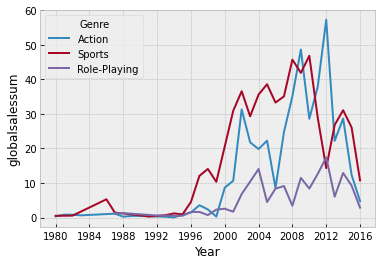

In [61]:
genrelineplot = pd.DataFrame(dfarima.groupby(['Year','Genre'], as_index=False).agg(globalsalessum=('Global_Sales', 'sum')))
sns.lineplot(data=genrelineplot,x='Year',y='globalsalessum', ci=None, hue='Genre')

<AxesSubplot:xlabel='Year', ylabel='globalsalessum'>

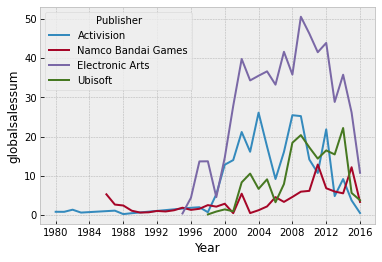

In [62]:
publisherlineplot = pd.DataFrame(dfarima.groupby(['Year','Publisher'], as_index=False).agg(globalsalessum=('Global_Sales', 'sum')))
sns.lineplot(data=publisherlineplot,x='Year',y='globalsalessum', ci=None, hue='Publisher')

## Feature Engineering for ARIMA Model

There is a clear change of sales in 2013, we will cut dates after 2013


In [63]:
def arima(dataset, p, q, d, len):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. AFD : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num of Lags : ", dftest[2])
    model = ARIMA(dataset, order = (p,q,d))
    model_fit = model.fit()
    print(model_fit.summary())
    plt.show()
    forecast = model_fit.forecast()
    print(forecast)
    

In [64]:
dfarima2013 = dfarima.loc[(dfarima['Year'] <= '2013-01-01')]

####  Since 1980 the Genre with the most sales have been
1. Action
2. Sports

In [65]:
genrearimadf2013 = pd.DataFrame(dfarima2013.groupby(['Year','Genre'], as_index=False).agg(globalsalessum=('Global_Sales', 'sum')))
action2013df = genrearimadf2013.loc[(genrearimadf2013['Genre'] == 'Action')]
action2013 = action2013df[['Year', 'globalsalessum']]
action2013 = action2013.set_index('Year')
sports2013df = genrearimadf2013.loc[(genrearimadf2013['Genre'] == 'Sports')]
sports2013 = sports2013df[['Year', 'globalsalessum']]
sports2013 = sports2013.set_index('Year')

### Action ARIMA

In [66]:
arima(action2013,0,1,1,29)

1. AFD :  1.6336362335298829
2. P-Value :  0.9979550599157606
3. Num of Lags :  9
                               SARIMAX Results                                
Dep. Variable:         globalsalessum   No. Observations:                   29
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -104.189
Date:                Thu, 16 Mar 2023   AIC                            212.378
Time:                        06:58:23   BIC                            215.042
Sample:                             0   HQIC                           213.192
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5143      0.117     -4.407      0.000      -0.743      -0.286
sigma2        98.8121     20.575      4.802      

### Sports ARIMA

In [67]:
arima(sports2013,0,1,0,29)

1. AFD :  -1.2855416970344122
2. P-Value :  0.6357607736878099
3. Num of Lags :  0
                               SARIMAX Results                                
Dep. Variable:         globalsalessum   No. Observations:                   29
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -93.949
Date:                Thu, 16 Mar 2023   AIC                            189.898
Time:                        06:58:23   BIC                            191.230
Sample:                             0   HQIC                           190.305
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        48.0767     11.722      4.101      0.000      25.102      71.051
Ljung-Box (L1) (Q):                   0.00   Jar

####  Since 1980 the Publishers with the most sales have been
1. Electronic Arts
2. Activision
3. Namco Bandai Games

In [68]:
publisherarimadf2013 = pd.DataFrame(dfarima2013.groupby(['Year','Publisher'], as_index=False).agg(globalsalessum=('Global_Sales', 'sum')))
ea2013 = publisherarimadf2013.loc[(publisherarimadf2013['Publisher'] == 'Electronic Arts')]
ea2013 = ea2013[['Year', 'globalsalessum']]
ea2013 = ea2013.set_index('Year')
activision2013 = publisherarimadf2013.loc[(publisherarimadf2013['Publisher'] == 'Activision')]
activision2013 = activision2013[['Year', 'globalsalessum']]
activision2013 = activision2013.set_index('Year')
namco2013 = publisherarimadf2013.loc[(publisherarimadf2013['Publisher'] == 'Namco Bandai Games')]
namco2013 = namco2013[['Year', 'globalsalessum']]
namco2013 = namco2013.set_index('Year')

### EA 

In [69]:
arima(ea2013,0,1,0,19)

1. AFD :  -3.3746753245797683
2. P-Value :  0.011853085471001874
3. Num of Lags :  6
                               SARIMAX Results                                
Dep. Variable:         globalsalessum   No. Observations:                   19
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -63.634
Date:                Thu, 16 Mar 2023   AIC                            129.267
Time:                        06:58:24   BIC                            130.157
Sample:                    01-01-1995   HQIC                           129.390
                         - 01-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        68.8933     30.638      2.249      0.025       8.844     128.942
Ljung-Box (L1) (Q):                   0.36   J

### Activision


In [70]:
arima(activision2013,0,1,0,25)

1. AFD :  -3.5815557721181945
2. P-Value :  0.006123591339089969
3. Num of Lags :  9
                               SARIMAX Results                                
Dep. Variable:         globalsalessum   No. Observations:                   25
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -79.785
Date:                Thu, 16 Mar 2023   AIC                            161.571
Time:                        06:58:24   BIC                            162.749
Sample:                             0   HQIC                           161.883
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        45.1932     12.807      3.529      0.000      20.093      70.294
Ljung-Box (L1) (Q):                   1.34   J

### Namco

In [71]:
arima(namco2013,0,1,1,28)

1. AFD :  0.8891116112729657
2. P-Value :  0.992946571945091
3. Num of Lags :  8
                               SARIMAX Results                                
Dep. Variable:         globalsalessum   No. Observations:                   28
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -58.885
Date:                Thu, 16 Mar 2023   AIC                            121.769
Time:                        06:58:24   BIC                            124.361
Sample:                    01-01-1986   HQIC                           122.540
                         - 01-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5079      0.161     -3.150      0.002      -0.824      -0.192
sigma2         4.5399      0.887      5.117      0

### Electronic Arts

In [72]:
arima(ea2013,0,1,0,19)

1. AFD :  -3.3746753245797683
2. P-Value :  0.011853085471001874
3. Num of Lags :  6
                               SARIMAX Results                                
Dep. Variable:         globalsalessum   No. Observations:                   19
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -63.634
Date:                Thu, 16 Mar 2023   AIC                            129.267
Time:                        06:58:24   BIC                            130.157
Sample:                    01-01-1995   HQIC                           129.390
                         - 01-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        68.8933     30.638      2.249      0.025       8.844     128.942
Ljung-Box (L1) (Q):                   0.36   J

### Activision

In [73]:
arima(activision2013,0,1,0,25)

1. AFD :  -3.5815557721181945
2. P-Value :  0.006123591339089969
3. Num of Lags :  9
                               SARIMAX Results                                
Dep. Variable:         globalsalessum   No. Observations:                   25
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -79.785
Date:                Thu, 16 Mar 2023   AIC                            161.571
Time:                        06:58:24   BIC                            162.749
Sample:                             0   HQIC                           161.883
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        45.1932     12.807      3.529      0.000      20.093      70.294
Ljung-Box (L1) (Q):                   1.34   J